# Annotation enrichemnts reversed

i.e. rather than asking if an eqtl variant is more likely than a pcqtl variant to be in an enhancer, ask if of the variants in an enhancer they are more likely to be found as pcqtls or eqtls



In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from tqdm import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_qtls import *

from scipy.stats import ttest_rel, ranksums
import statsmodels.api as sm

import scipy.stats as stats



In [5]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

### load data

In [41]:
my_tissue_id = ['Lung']

In [11]:
abc = load_abc(my_tissue_id)

In [42]:
# nominal p values
pc_nominal = load_across_tissues(config, load_pc_nominal, my_tissue_id)
e_nominal = load_across_tissues(config, load_e_nominal, my_tissue_id)

In [55]:
# group to get each varaints mimimum p value for any phenoytpe
e_nominal_var = e_nominal.groupby(['variant_id', 'tissue_id']).agg({'pval_nominal':min, 
                                                                    'cluster_id':'first'})
pc_nominal_var = pc_nominal.groupby(['variant_id', 'tissue_id']).agg({'pval_nominal':min})

# merge pc and e together
nominal_merged = pd.merge(pc_nominal_var, e_nominal_var, on=['variant_id', 'tissue_id'], suffixes=['_pc', '_e']).reset_index()
nominal_merged['chr'] = nominal_merged['variant_id'].str.split('chr').str[1].str.split('_').str[0].astype(int)
nominal_merged['position'] = nominal_merged['variant_id'].str.split('_').str[1].astype(int)

In [77]:
annotate_enhancers_qtl(nominal_merged, abc)

 ... (more hidden) ...


(0.0, 8.0)

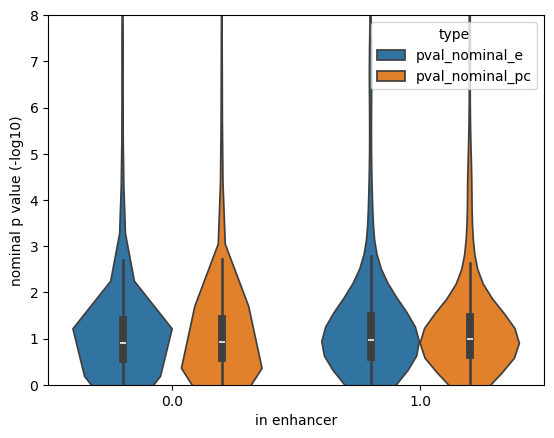

In [82]:
nominal_metled = nominal_merged.melt(id_vars=['tissue_id', 'variant_id', 'qtl_num_abc_enhancers'], var_name='type', value_name='pval_nominal', value_vars = ['pval_nominal_e', 'pval_nominal_pc'])
nominal_metled['log_p'] = -np.log10(nominal_metled['pval_nominal'])
ax = sns.violinplot(nominal_metled, hue='type', y='log_p', x='qtl_num_abc_enhancers')
ax.set_xlabel('in enhancer')
ax.set_ylabel('nominal p value (-log10)')
ax.set_ylim(0, 8)

TtestResult(statistic=2.9645950103055196, pvalue=0.0031067745990985027, df=947)
RanksumsResult(statistic=0.7564191640822233, pvalue=0.44939792154193303)


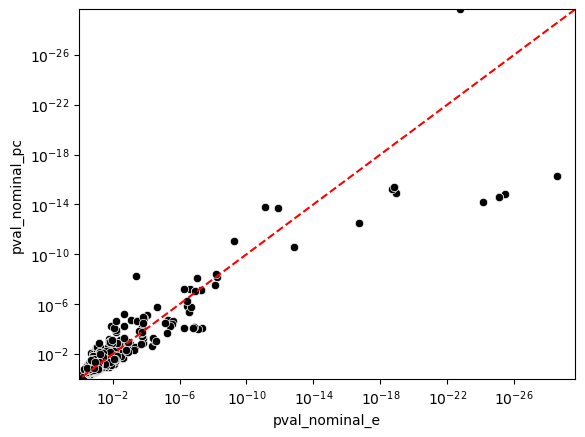

In [ ]:
in_enhancer = nominal_merged[nominal_merged['qtl_num_abc_enhancers']>0]

ax = sns.scatterplot(in_enhancer, x='pval_nominal_e', y='pval_nominal_pc', color='k')

ax_lims = [pd.concat([in_enhancer['pval_nominal_e'], in_enhancer['pval_nominal_pc']]).min(),1]
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_yaxis()
ax.invert_xaxis()

x = in_enhancer['pval_nominal_e']
y = in_enhancer['pval_nominal_pc']
print(ttest_rel(x, y))
print(ranksums(x, y))

## linear model predictor

<AxesSubplot: xlabel='size_diff', ylabel='Count'>

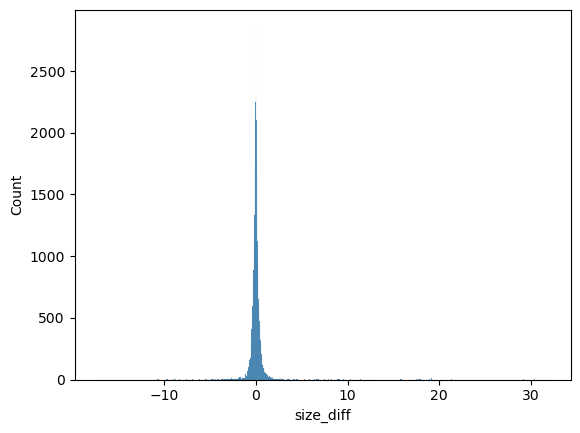

In [104]:
nominal_merged['size_diff'] = -np.log10(nominal_merged['pval_nominal_pc']) - -np.log10(nominal_merged['pval_nominal_e'])
sns.histplot(nominal_merged['size_diff'])

# positive means pc is better/lower p value

In [122]:
# predictor for p value difference
X = nominal_merged[['qtl_num_abc_enhancers']]
y = nominal_merged['size_diff']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              size_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.821
Date:                Thu, 14 Nov 2024   Prob (F-statistic):            0.00901
Time:                        16:53:57   Log-Likelihood:            -1.2062e+05
No. Observations:               77162   AIC:                         2.412e+05
Df Residuals:                   77160   BIC:                         2.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.05

In [124]:
# predictor for p value difference
X = nominal_merged[['qtl_num_abc_enhancers', 'qtl_matched_abc_genes']]
y = nominal_merged['size_diff']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              size_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.213
Date:                Thu, 14 Nov 2024   Prob (F-statistic):             0.0148
Time:                        16:54:29   Log-Likelihood:            -1.2061e+05
No. Observations:               77162   AIC:                         2.412e+05
Df Residuals:                   77159   BIC:                         2.413e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.05

In [121]:
# predictor for p value difference
X = nominal_merged[nominal_merged['qtl_num_abc_enhancers']>0][['qtl_num_abc_genes']]
y = nominal_merged[nominal_merged['qtl_num_abc_enhancers']>0]['size_diff']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              size_diff   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.282
Date:                Thu, 14 Nov 2024   Prob (F-statistic):              0.131
Time:                        16:53:35   Log-Likelihood:                -1342.2
No. Observations:                 948   AIC:                             2688.
Df Residuals:                     946   BIC:                             2698.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0638      0.03

In [165]:
in_enhancer_melted = in_enhancer.melt(id_vars=['tissue_id', 'variant_id', 'qtl_num_abc_enhancers'], var_name='type', value_name='pval_nominal', value_vars = ['pval_nominal_e', 'pval_nominal_pc'])


Text(0, 0.5, 'pcQTL -log10(p)')

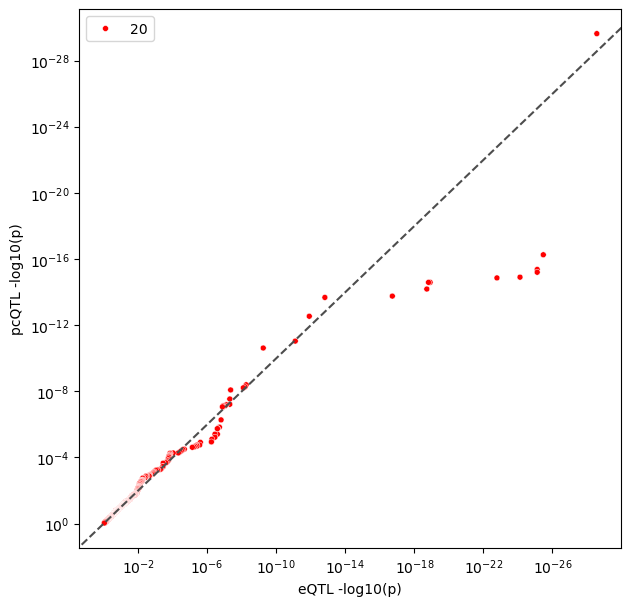

In [ ]:
# Sort the data
sorted_e = np.sort(in_enhancer['pval_nominal_e'])
sorted_pc = np.sort(in_enhancer['pval_nominal_pc'])
uniform = np.random.uniform(low=-3, high=3, size=1000)  # Uniform distribution

# Calculate quantiles
n = len(sorted_e)

# Obtain quantiles (same number for both datasets)
# For the Q-Q plot, we match quantiles of two distributions
quantiles_e = np.percentile(sorted_e, np.linspace(0, 100, n))
quantiles_pc = np.percentile(sorted_pc, np.linspace(0, 100, n))
quantiles_uniform = np.percentile(uniform, np.linspace(0, 100, n))

f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.invert_xaxis()
ax.invert_yaxis()

sns.scatterplot(x=quantiles_e, y=quantiles_pc, color='r', size=20, ax=ax)
ax.set(yscale="log", xscale="log")

ax.set_xlabel('eQTL -log10(p)')
ax.set_ylabel('pcQTL -log10(p)')



#### for ctcf

In [ ]:
tad_df = load_tad('{}/{}'.format(prefix, config['tad_path']))
ctcf_df = load_ctcf(my_tissue_id[0], '{}/{}'.format(prefix, config['ctcf_match_path']), '{}/{}'.format(prefix, config['ctcf_dir']))
gid_gencode, full_gencode = load_gencode()

ctcf_df = ctcf_df[ctcf_df['chr'].isin([f'chr{i}' for i in range(23)])]
ctcf_df['chr'] = ctcf_df['chr'].str.split('chr').str[1].astype(int)

In [152]:
ctcf_df['interval'] = ctcf_df.apply(lambda row: pd.Interval(left=row['start'], right=row['end'], closed='both'), axis=1)

def check_within_intervals(row):
    chr_intervals = ctcf_df[ctcf_df['chr'] == row['chr']]['interval']
    return any(row['position'] in interval for interval in chr_intervals)


/local/scratch/klawren/slrmtmp.46845187/ipykernel_1525/1036161421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctcf_df['interval'] = ctcf_df.apply(lambda row: pd.Interval(left=row['start'], right=row['end'], closed='both'), axis=1)


In [155]:
nominal_merged['qtl_in_ctcf'] = nominal_merged.apply(check_within_intervals, axis=1)


TtestResult(statistic=2.9645950103055196, pvalue=0.0031067745990985027, df=947)
RanksumsResult(statistic=0.7564191640822233, pvalue=0.44939792154193303)


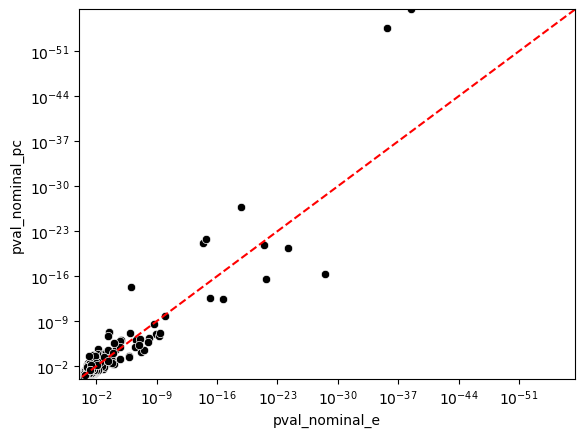

In [156]:
in_ctcf = nominal_merged[nominal_merged['qtl_in_ctcf']>0]

ax = sns.scatterplot(in_ctcf, x='pval_nominal_e', y='pval_nominal_pc', color='k')

ax_lims = [pd.concat([in_ctcf['pval_nominal_e'], in_ctcf['pval_nominal_pc']]).min(),1]
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_xscale('log')
ax.set_yscale('log')
ax.invert_yaxis()
ax.invert_xaxis()

x = in_enhancer['pval_nominal_e']
y = in_enhancer['pval_nominal_pc']
print(ttest_rel(x, y))
print(ranksums(x, y))

In [159]:
# predictor for p value difference
X = nominal_merged[['qtl_in_ctcf']].astype(int)
y = nominal_merged['size_diff']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              size_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1592
Date:                Thu, 14 Nov 2024   Prob (F-statistic):              0.690
Time:                        17:32:10   Log-Likelihood:            -1.2062e+05
No. Observations:               77162   AIC:                         2.412e+05
Df Residuals:                   77160   BIC:                         2.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0557      0.004     13.340      

In [186]:
in_ctcf = nominal_merged[nominal_merged['qtl_in_ctcf']]

Text(0, 0.5, 'pcQTL -log10(p)')

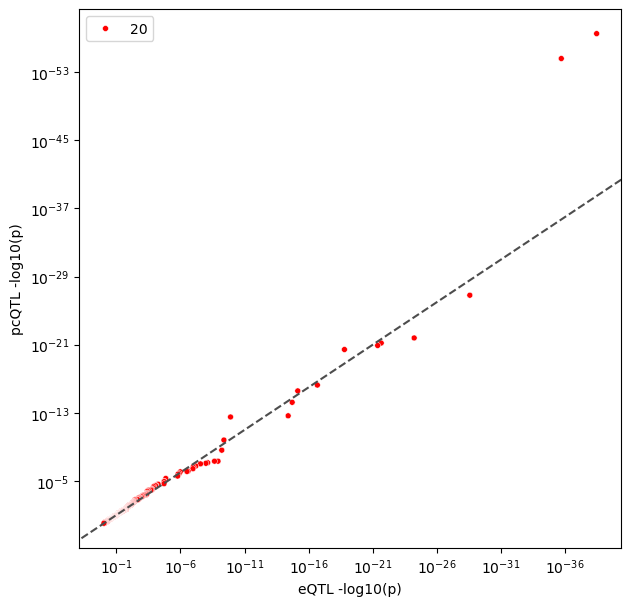

In [187]:
sorted_e = np.sort(in_ctcf['pval_nominal_e'])
sorted_pc = np.sort(in_ctcf['pval_nominal_pc'])

# Calculate quantiles
n = len(sorted_e)

# Obtain quantiles (same number for both datasets)
# For the Q-Q plot, we match quantiles of two distributions
quantiles_e = np.percentile(sorted_e, np.linspace(0, 100, n))
quantiles_pc = np.percentile(sorted_pc, np.linspace(0, 100, n))

f, ax = plt.subplots(figsize=(7, 7))
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.invert_xaxis()
ax.invert_yaxis()

sns.scatterplot(x=quantiles_e, y=quantiles_pc, color='r', size=20, ax=ax)
ax.set(yscale="log", xscale="log")

ax.set_xlabel('eQTL -log10(p)')
ax.set_ylabel('pcQTL -log10(p)')